# 演習（線形二値分類）

本演習では、線形モデルを用いた二値分類の学習アルゴリズムとして、パーセプトロンを実装してみる。

まず、必要最低限のモジュールを読み込み、乱数関係を担ってくれるGeneratorを作っておく。

In [1]:
# 外部モジュール
import matplotlib.pyplot as plt
import numpy as np

# 乱数を作ってくれるGeneratorの準備
random_seed = 173912158754542868191087867204820885917 # 固定する場合
#random_seed = np.random.SeedSequence().entropy # 毎回新しいseedを使う場合
rg = np.random.default_rng(random_seed)

次に、データをランダムに生成し、二次元平面にプロットする。

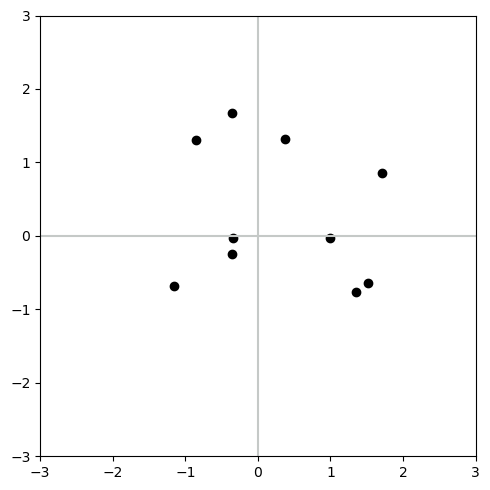

In [2]:
n_tr = 10
X_tr = rg.multivariate_normal(mean=np.zeros((2,)),
                              cov=np.eye(N=2),
                              size=(n_tr,))
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[:,0], X_tr[:,1], marker="o", color="xkcd:black")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

### 演習課題

__(1.1) 乱数シードを変えてみる__

上述の例では、`random_seed`を適当な正の整数に固定しているので、このnotebookのリセット後に頭から実行すれば、毎回、必ず同じデータになる。この挙動を予測できないランダムなものに変えるには、コード中にコメントされている行（先頭に`#`をつけているところ）を使ってみよう。あえてこのシードを固定する意味は何か、考察しよう。

__(1.2) データ分布を変更してみる__

上述の例では、`X_tr`は正規分布に従うデータになっているが、numpyの機能として多種多様の分布が備わっている。たとえば、一様分布などからも簡単にデータを生成することができる。以下の要点にしたがって、タテヨコの両軸において-2.5と2.5の間に一様に分布するデータを生成してみよう。

- Generatorである`rg`のメソッドを実行することは変わらないが、もともと使っている`multivariate_normal`ではなく、`uniform`を使う。
- [numpyのドキュメンテーション](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.uniform.html)からもわかるように、`uniform`には引数が3つある（`low`, `high`, `size`）。`low`と`high`は生成する範囲の下限と上限で、`size`は生成される配列のカタチである。
- データの数は変わらず`n_tr`を渡せば良いが、2次元平面上のの一様分布から生成したいので、`size`を`(n_tr,2)`に設定する必要がある。

## 簡単な例を実装してみる

まず、二値分類の問題を考えたいので、「正例」と「負例」に分けておく。下図の破線を境界としてラベルを付与する。

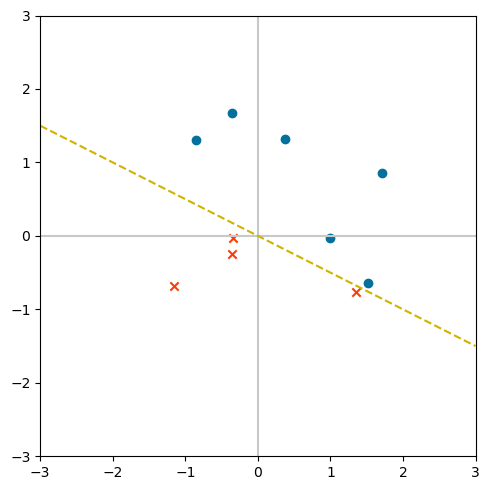

In [3]:
def linear_separator(X):
    '''
    真のラベルづけの規則
    '''
    w_0 = 0.0
    w_1 = 1.0
    w_2 = 2.0
    scores = w_1 * X[:,0] + w_2 * X[:,1] - w_0
    return np.where(scores <= 0, 0, 1)

def draw_line(x, w):
    '''
    ラベルづけ規則を可視化してくれる
    '''
    y = (w[0]/w[2]) - (w[1]/w[2]) * x
    return y


# ラベルたち
Y_tr = linear_separator(X=X_tr)

# ラベルを図示したプロット
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr == 0
idx_1 = Y_tr == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

学習問題では、この「真の規則」は未知である。持っているのはデータだけである。線形モデルを使う前提で、パーセプトロンを何度か実行して、その学習結果を図示していこう。

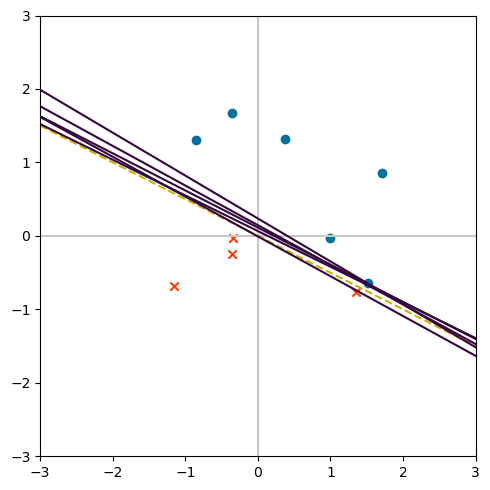

In [4]:
X_tr_padded = np.column_stack([-np.ones(shape=(len(X_tr),1)), X_tr])
num_runs = 5
candidate_list = []

# 指定された回数だけ実行して、学習の結果を保存しておく
for i in range(num_runs):

    # 初期化
    w_candidate = rg.uniform(low=-3, high=3, size=(3,))

    # 正誤を求める
    scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
    labels = np.where(scores <= 0, 0, 1)
    losses_TF = labels != Y_tr
    losses_01 = np.where(losses_TF, 1, 0)
    num_wrong = losses_01.sum()
    
    # 全問正解でない限り更新していく
    while num_wrong > 0:
        idx_wrong = np.arange(len(X_tr))[losses_TF]
        idx = rg.choice(a=idx_wrong, size=1)
        x_wrong = X_tr_padded[idx,:].flatten() # 注意：ここだけpadded版を使う
        y_wrong = Y_tr[idx]
        if y_wrong == 1:
            sign_wrong = 1
        else:
            sign_wrong = -1 # 注意：ラベルは0と1だったための補正

        # 更新
        w_candidate += sign_wrong * x_wrong

        # 正誤を再び求める
        scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
        labels = np.where(scores <= 0, 0, 1)
        losses_TF = labels != Y_tr
        losses_01 = np.where(losses_TF, 1, 0)
        num_wrong = losses_01.sum()
    
    candidate_list += [np.copy(w_candidate)]

# 学習結果を図示
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr == 0
idx_1 = Y_tr == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
for w_candidate in candidate_list:
    line_vert = draw_line(x=line_horiz, w=w_candidate)
    ax.plot(line_horiz, line_vert, ls="solid", color="xkcd:dark purple")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

案の定、初期値や誤分類された点を見る順番の違いにかかわらず、全問正解の識別線を見つけてくれている。

### 演習課題

__(1.3) ラベルづけのメカニズムを変えてみる__

先述の例では、正例と負例のラベルづけは黄色い破線で表示される識別線によって決まる。この「背後にある規則」を変更してみよう。たとえば、切片1.0、傾き1.0の線に変更し、再度データをプロットしてみよう。ヒント：関数`linear_separator`の定義（`def linear_separator(X):`で始まる箇所）に目を通して、その中身に手を加えれば良い。

## もう少し難しい状況を考える

次に考えたいのは、ラベルづけの規則が不確かで、線形分離可能性が成り立たない場合である。つまり、「全問正解が可能である」という前提を外す。このときの従来のパーセプトロンの成績を眺めてみよう。

まず、元々扱っていたデータを少し改変し、ノイジーなものにしていく。

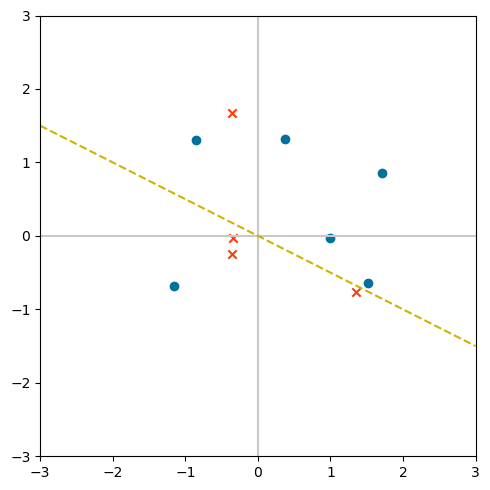

In [5]:
# ラベルを無作為に変更させる（＝ノイズ）
noise_rate = 0.2
Y_tr_noisy = np.copy(Y_tr)
idx_to_flip = rg.integers(low=0, high=len(Y_tr_noisy), size=max(1,int(noise_rate*len(Y_tr_noisy))))
Y_tr_noisy[idx_to_flip] = (Y_tr_noisy[idx_to_flip] + 1) % 2

# ラベルを図示したプロット
fig, ax = plt.subplots(1, 1, figsize=(5,5))
idx_0 = Y_tr_noisy == 0
idx_1 = Y_tr_noisy == 1
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.scatter(X_tr[idx_0,0], X_tr[idx_0,1], marker="x", color="xkcd:red orange")
ax.scatter(X_tr[idx_1,0], X_tr[idx_1,1], marker="o", color="xkcd:ocean blue")
line_horiz = np.linspace(-3, 3, 100)
line_vert = draw_line(x=line_horiz, w=np.array([0.0, 1.0, 2.0]))
ax.plot(line_horiz, line_vert, ls="dashed", color="xkcd:mustard")
ax.set_xlim(left=-3.0, right=3.0)
ax.set_ylim(bottom=-3.0, top=3.0)
plt.tight_layout()
plt.show()

このデータを受けて、従来のパーセプトロンを実行してみよう。

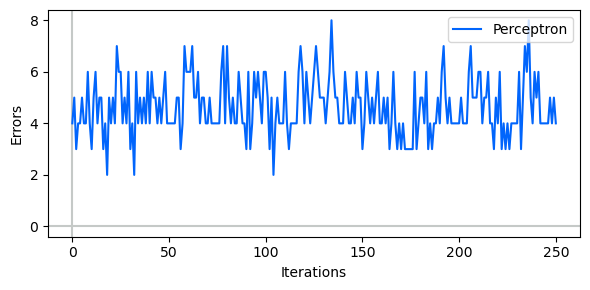

In [6]:
# 反復回数の上限を設ける
max_iterations = 250

# 初期化
w_candidate = rg.uniform(low=-3, high=3, size=(3,))

# 誤答数を記録するためのリスト
num_wrong_list = []

# 正誤を求める
scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
labels = np.where(scores <= 0, 0, 1)
losses_TF = labels != Y_tr_noisy # 注意：ノイズあり
losses_01 = np.where(losses_TF, 1, 0)
num_wrong = losses_01.sum()
num_wrong_list += [num_wrong]

# パーセプトロンの実行（但し回数に上限あり）
for t in range(max_iterations):

    if num_wrong == 0:
        break

    else:
        idx_wrong = np.arange(len(X_tr))[losses_TF]
        idx = rg.choice(a=idx_wrong, size=1)
        x_wrong = X_tr_padded[idx,:].flatten()
        y_wrong = Y_tr_noisy[idx] # 注意：ノイズあり
        if y_wrong == 1:
            sign_wrong = 1
        else:
            sign_wrong = -1

        # 更新
        w_candidate += sign_wrong * x_wrong

        # 正誤を再び求める
        scores = w_candidate[1] * X_tr[:,0] + w_candidate[2] * X_tr[:,1] - w_candidate[0]
        labels = np.where(scores <= 0, 0, 1)
        losses_TF = labels != Y_tr_noisy # 注意：ノイズあり
        losses_01 = np.where(losses_TF, 1, 0)
        num_wrong = losses_01.sum()
        num_wrong_list += [num_wrong]

# 誤答数の推移を図示する
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.axvline(x=0.0, color="xkcd:silver")
ax.axhline(y=0.0, color="xkcd:silver")
ax.plot(np.arange(0, len(num_wrong_list), 1), np.array(num_wrong_list),
        ls="solid", color="xkcd:bright blue", label="Perceptron")
plt.xlabel("Iterations")
plt.ylabel("Errors")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

残念ながら、いくら更新しても、無作為に決めた初期値と変わらない成績が起こりうる。

__(1.4) パーセプトロンの挙動を確認する__

最初の例では、線形分離可能なデータを生成しているので、パーセプトロンは十分な反復回数を経ていけば、必ず「全問正解」に到達することは前もってわかっている。つまり、繰り返しの条件文「`while num_wrong > 0:`」は安心して使える（無限に走り続けることはない）。一方、先ほどの「ノイズあり」の状況では、線形分類可能でない可能性が高く、`while`を使ったループは終了しない。上記のコードブロックでは「`for t in range(max_iterations):`」つまり反復回数の上限を設けているが、「時間をかければかけるほど良い候補を得る」というのは期待できず、性能が非常に不安定になっていることは明らかである。

そこで、反復回数の上限を設けた上で、最終回でもう少しまともな候補が手に入る方法を考案し、余力があれば実装し、誤答数の推移をプロットしてみよう。